In [154]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [155]:
from pathlib import Path
from PIL import Image
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        try:
            with Image.open(filepath) as img:
                img_type = img.format.lower()
                if img_type is None:
                    print(f"{filepath} is not an image")
                    os.remove(filepath)
                elif img_type not in img_type_accepted_by_tf:
                    print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                    os.remove(filepath)

        except (IOError, OSError) as e:
            print(f"Error opening {filepath}: {e}")

In [156]:
from tensorflow import keras

image_size = (64, 64)
batch_size = 32

class_names = ["Curly_Hair", "Straight_Hair", "Wavy_Hair"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

KeyboardInterrupt: 

In [ ]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


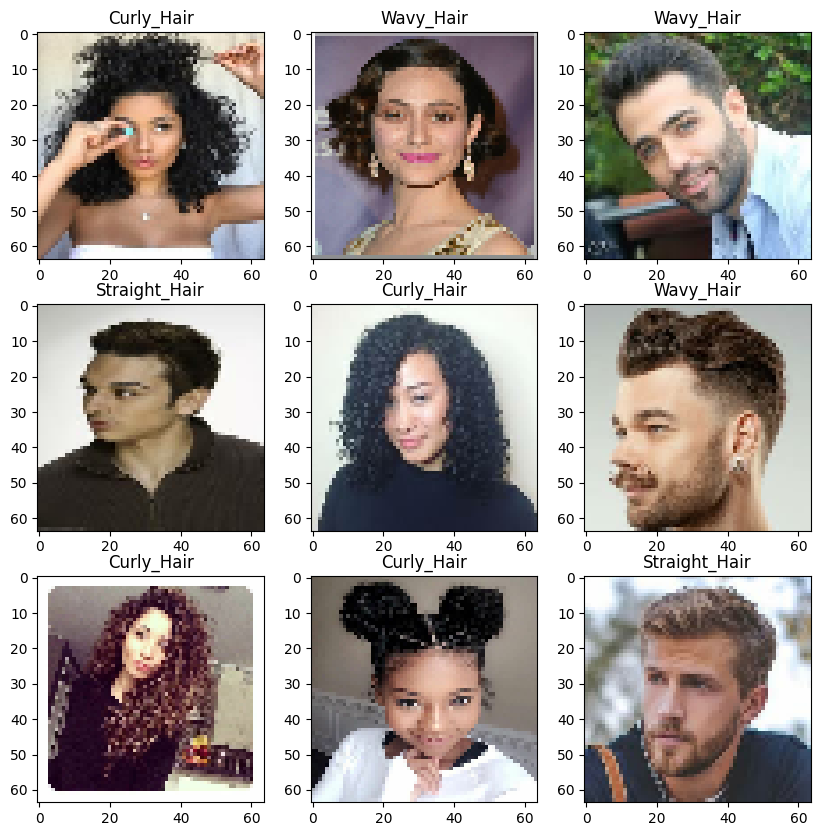

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", input_shape=(64, 64, 3)),
        layers.RandomRotation(factor=0.4),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

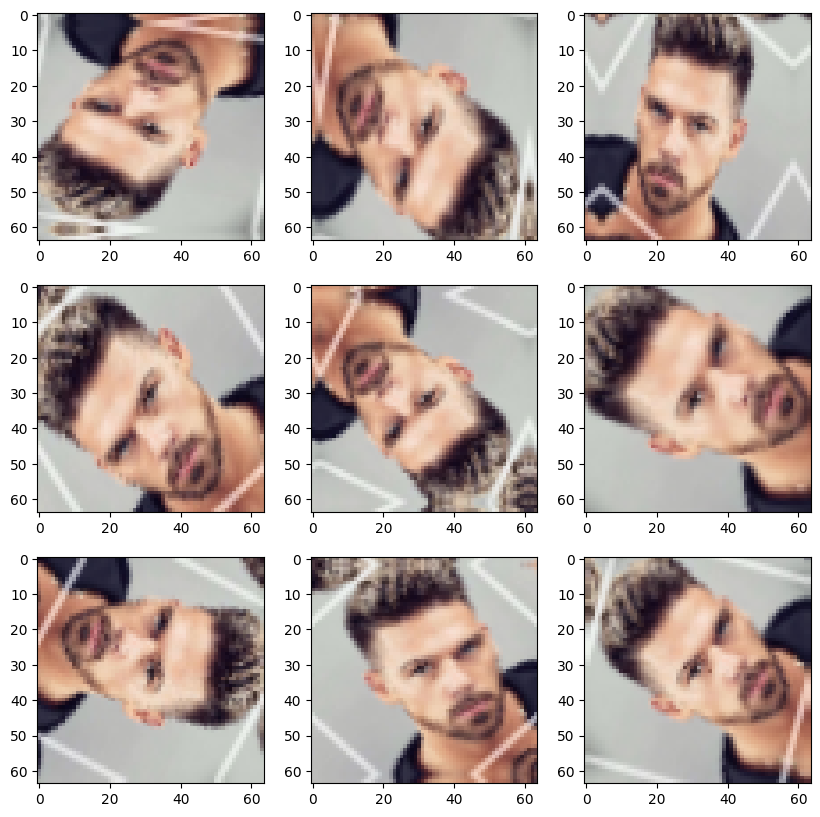

In [ ]:
sample_images = train_ds.take(1)
for images, _ in sample_images:
    sample_image = images[0]
    break

# Reshape the image for data augmentation
image = tf.expand_dims(sample_image, 0)
image = tf.cast(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))

plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

In [ ]:
# Define a function to build your model
def build_model(hp):
    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = inputs

    for i in range(hp.Int("conv_layers", 1, 3, default=3)):
        x = tf.keras.layers.Conv2D(
            filters=hp.Int(f"filters_{i}", min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5]),
            activation="relu",
            padding="same",
            strides=1,
        )(x)

        if hp.Choice("pooling" + str(i), ["max", "avg"]) == "max":
            x = tf.keras.layers.MaxPooling2D()(x)
        else:
            x = tf.keras.layers.AveragePooling2D()(x)

        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.ReLU()(x)

    if hp.Choice("global_pooling", ["max", "avg"]) == "max":
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [ ]:
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping


tuner = Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory="my_tuning_dir",
    project_name="hair_types",
    overwrite=True,
)

# Parallelize trials (assuming you have access to multiple processing units)
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy")],
)

Trial 10 Complete [00h 00m 34s]
val_accuracy: 0.4111675024032593

Best val_accuracy So Far: 0.4720812141895294
Total elapsed time: 00h 04m 03s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it on the data
model = build_model(best_hps)

In [ ]:
# Retrieve the configuration of the best hyperparameters
best_hyperparameters = best_hps.get_config()

# Print the best hyperparameters in a readable format
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
space: [{'class_name': 'Int', 'config': {'name': 'conv_layers', 'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'filters_0', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'kernel_size_0', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'pooling0', 'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}}, {'class_name': 'Int', 'config': {'name': 'filters_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'kernel_size_1', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'pooling1', 'default': 'max', 'conditions': [], 'valu

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
)

In [ ]:
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping],
)

Epoch 1/100


25/25 [==============================] - 5s 119ms/step - loss: 1.0932 - accuracy: 0.3883 - val_loss: 1.6072 - val_accuracy: 0.3452
Epoch 2/100
25/25 [==============================] - 3s 113ms/step - loss: 1.0520 - accuracy: 0.4569 - val_loss: 1.2114 - val_accuracy: 0.3503
Epoch 3/100
25/25 [==============================] - 3s 112ms/step - loss: 1.0386 - accuracy: 0.4924 - val_loss: 1.2082 - val_accuracy: 0.3452
Epoch 4/100
25/25 [==============================] - 3s 113ms/step - loss: 1.0220 - accuracy: 0.4987 - val_loss: 1.0787 - val_accuracy: 0.4061
Epoch 5/100
25/25 [==============================] - 4s 124ms/step - loss: 1.0181 - accuracy: 0.5089 - val_loss: 1.3996 - val_accuracy: 0.2741
Epoch 6/100
25/25 [==============================] - 3s 116ms/step - loss: 1.0056 - accuracy: 0.5127 - val_loss: 1.2879 - val_accuracy: 0.3299
Epoch 7/100
25/25 [==============================] - 4s 116ms/step - loss: 0.9972 - accuracy: 0.5076 - val_loss: 2.4375 - val_accuracy: 0.2843
Epoch 8/100

In [ ]:
tf.keras.utils.plot_model(model, to_file="model_experiment9.png", show_shapes=True)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 96)        2688      
                                                                 
 average_pooling2d_1 (Avera  (None, 32, 32, 96)        0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 96)        384       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 32, 32, 96)        0         
                                                                 
 global_average_pooling2d_1  (None, 96)                0   

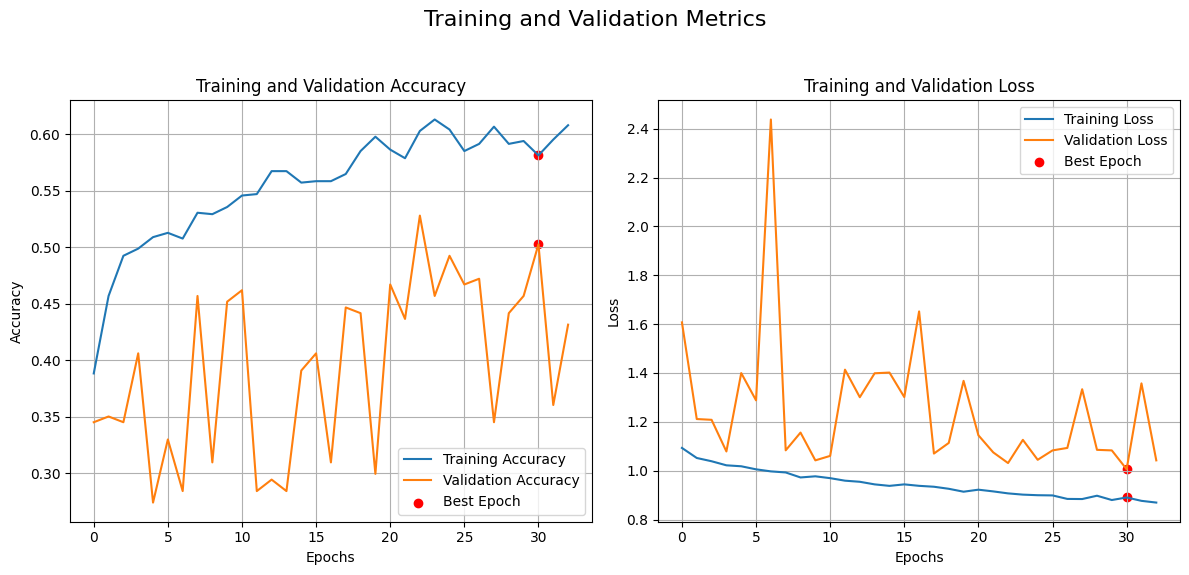

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

best_epoch = np.argmin(val_loss)

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.scatter(best_epoch, acc[best_epoch], color="red")
plt.scatter(best_epoch, val_acc[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.scatter(best_epoch, loss[best_epoch], color="red")
plt.scatter(best_epoch, val_loss[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.grid(True)

plt.suptitle("Training and Validation Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
print(f"Best Epoch: {best_epoch + 1}")
print(f"Accuracy at Best Epoch: {acc[best_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
print(f"Loss at Best Epoch: {loss[best_epoch]:.4f}")
print(f"Validation Loss at Best Epoch: {val_loss[best_epoch]:.4f}")

Best Epoch: 31
Accuracy at Best Epoch: 0.5812
Validation Accuracy at Best Epoch: 0.5025
Loss at Best Epoch: 0.8903
Validation Loss at Best Epoch: 1.0060


In [ ]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg",
    target_size=image_size,
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

1/1 [==============================] - 0s 21ms/step
This image is 0.89 percent curly hair, 0.06 percent straight hair, and 0.05 percent wavy hair.
